Look two other kinds of computer vision problems:
- Multi-label classification
  - predict more than one label per image
- Regression
  - when labels are one or several numbers
  - quantity instead of category

deep understanding of:
- output activations
- targets
- loss functions

## Multi-label Classification
refers to the problem of identifying the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes you are looking for.

### The Data
use the PASCAL dataset, which can have more than one kind of classified object per image

In [1]:
# downloading and extracting the dataset as per usual:

from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
# this dataset comes with a CSV file
# inspect the CSV file by reading it into a Pandas DataFrame:

df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


#### Pandas and DataFrames
The main class is DataFrame, which represents a table of rows and columns.

Get a DataFrame from a CSV file, a database table, Python dictionaries.

access rows and columns of a DataFrame with the iloc property, as if it were a matrix:

In [3]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [4]:
df.iloc[0,:]
# Training :s are always optional (in numpy, pytorch, pandas, etc)
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
# You can also grab a column by name by indexing into a DataFrame directly:

df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
# You can create new columns and do calculations using columns:

df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]
df1

,a
0,1
1,2
2,3
3,4


In [7]:
df1['b'] = [10, 20, 30, 40]
df1['a'] + df1['b']

0    11
1    22
2    33
3    44
dtype: int64

**make data ready for model training**

### Constructing a DataBlock
data block API: convert DataFrame to DataLoaders

In [8]:
# start with the simplest case, which is a data block created with no parameters:

dblock = DataBlock()

In [9]:
# create a Datasets object from this using dataframe

dsets = dblock.datasets(df)

In [10]:
# This contains a train and a valid dataset, which we can index into:

dsets.train[0]

(fname       000304.jpg
 labels       tvmonitor
 is_valid          True
 Name: 150, dtype: object, fname       000304.jpg
 labels       tvmonitor
 is_valid          True
 Name: 150, dtype: object)

In [11]:
# grab the appropriate fields from the DataFrame by passing get_x and get_y functions:

dblock = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004512.jpg', 'dog person chair')

In [12]:
# The following more verbose approach is identical:

def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002172.jpg', 'motorbike person')

In [13]:
# independent var: in complete path, we can open it as an image
# dependent var: in list

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/008381.jpg'), ['person'])

In [14]:
# open the image and do the conversion to tensors
# ImageBlock:a path that points to a valid image
# MultiCategoryBlock:multiple labels for each item

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=333x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

Single integer representing which category was present.

__one-hot encoding__: list of 0s, with a 1 in any position where that category is present.

In [15]:
# check what the categories represent for this example:

idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['car','person']

is_valid column is ignored means DataBlock using a random split by default.

To choose the elements of out validation set, need to write a function and pass it to splitter.

In [16]:
# take the item(DataFrame) return two(or more) list of integers:

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

In [17]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [27]:
# create our DataLoaders
# which ensure that every item is of the same size(using RandomResizedCrop):

dlblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=splitter,
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

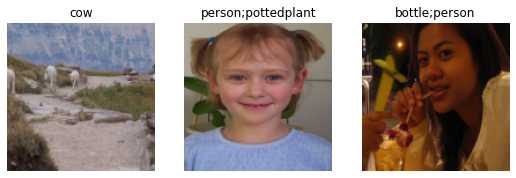

In [28]:
# display a sample of data:

dls.show_batch(nrows=1, ncols=3)

## Binary Cross Entropy
Learner
  - the model : leverage fastai's resnet
  - a DataLoaders object : dls
  - an Optimizer : SGD optimizer
  - the loss function : now ensure we have a suitable loss fn



In [29]:
# use cnn_learner to create a Learner, so we can look at its activations:

learn = cnn_learner(dls, resnet18)

model in a Learner: an object of a class inheriting from nn.Module, returns activations of a model.

In [38]:
# grab a mini-batch from our DataLoader and then passing it to the model:
learn.model.cuda()
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

activation shape
  - batch of 64
  - calculate the probability of each of 20 categories

In [39]:
activs[0]

TensorBase([-4.2942, -4.8542, -4.1478, -5.0459, -5.3384, -4.2402, -4.1978, -3.1607,
         3.2762, -4.5998,  0.2574, -3.3869, -3.3886, -4.9158, -2.2373,  0.3927,
        -5.3183, -0.3745, -4.7047, -2.3530], device='cuda:0',
       grad_fn=<AliasBackward0>)

- using sigmoid fn: scale to bet 0 and 1
- loss fn: calculate a loss based on this
- log

In [31]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Because we have a one-hot-encoded dependent variable, can't directly use nll_loss or softmax (therefore we can't use cross_entropy)

binary_cross_entropy = mnist_loss along with log

Each activations will be campared to each target for each column, so we don't have to do anything to make this fn work for multiple columns

PyTorch already provides this function:
- F.binary_cross_entropy and its module equivalent nn.BCELoss: calculate cross entropy on a one-hot-encoded target, not include the initial sigmoid.
- F.binary_cross_entropy_with_logits(or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy

In [40]:
# for one-hot-encoded target, use BCEWithLogitsLoss:

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(0.0782, device='cuda:0', grad_fn=<AliasBackward0>)

fastai knows that the DataLoaders has multiple category labels, so it will use nn.BCEWithLogitsLoss by default

In [33]:
# can't use accuracy fn: it comparing our outputs to our targets like so:

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

after appyling sigmoid to our activations, need to decide which ones are 0s and which ones are 1s by picking threshold.
- value > threshold: 1
- value < threshold: 0 

In [34]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [35]:
# adjust that default and create a new version of accuracy_multi that has a different default
# use python func called partial:

def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [36]:
# switch to a French version of that function by using partial:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [37]:
# train our model
# setting the accuracy threshold to 0.2 for our metric:

learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947220,0.696618,0.243048,00:45
1,0.825027,0.562320,0.287968,00:41
2,0.609173,0.201190,0.824143,00:40
3,0.362590,0.126961,0.938665,00:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133567,0.114765,0.944741,00:48
1,0.118236,0.110819,0.946016,00:46
2,0.098535,0.105993,0.952490,00:46


Picking threshold too low: failing to select correctly labeled objects

In [41]:
# changing our metric and then calling validate
# return the validation loss and metrics:

learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10599251836538315,0.9330279231071472]

Pick a threshold that's too high, selecting only objects that the model is very confident

In [42]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10599251836538315,0.9436455368995667]

Find the best threshold by trying a few levels and seeing what works best

In [43]:
# this is much faster if we grabe the predictions just once:
preds, targs = learn.get_preds()

In [44]:
# call the metric directly
# tell accuracy_multi to not apply o/p activation fn(sigmoid)
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9559)

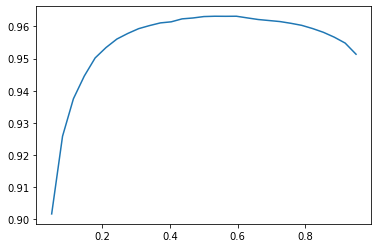

In [45]:
# use this approach to find the best threshold level:

xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);